In [1]:
import pandas as pd
import scutquant.scutquant as q

df = pd.read_csv("D:/Desktop/data.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df["mean_price"] = df["amount"] / df["vol"] * 10  # 每支股票在当天的交易均价
df

,datetime,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount,mean_price
0,2006-01-04,000001.SZ,6.13,6.33,6.12,6.28,6.14,0.14,2.2800,154450.68,96989.0066,6.279610
1,2006-01-04,000002.SZ,4.40,4.67,4.40,4.66,4.31,0.35,8.1200,389310.43,175187.0657,4.499933
2,2006-01-04,000012.SZ,4.70,4.75,4.55,4.70,4.62,0.08,1.7300,40399.61,18863.8625,4.669318
3,2006-01-04,000016.SZ,3.52,3.58,3.52,3.57,3.52,0.05,1.4200,14426.65,5131.8793,3.557222
4,2006-01-04,000021.SZ,7.99,8.40,7.99,8.32,8.00,0.32,4.0000,33526.60,27657.1708,8.249322
...,...,...,...,...,...,...,...,...,...,...,...,...
1199440,2022-12-30,688363.SH,136.00,137.00,131.50,135.28,135.49,-0.21,-0.1550,29951.60,401624.1560,134.091052
1199441,2022-12-30,688396.SH,53.06,53.40,52.49,52.65,52.87,-0.22,-0.4161,23401.54,123568.2880,52.803486
1199442,2022-12-30,688561.SH,65.49,67.88,64.85,65.77,65.46,0.31,0.4736,22567.89,149379.0770,66.190981
1199443,2022-12-30,688599.SH,63.31,64.56,62.31,63.76,63.20,0.56,0.8861,109144.36,695759.9350,63.746760


In [2]:
df.set_index(["datetime", "ts_code"], inplace=True)
df.index.names = ["datetime", "instrument"]

interest_data = pd.read_csv("D:/Desktop/capm.csv")
interest_data["RF"] = interest_data["RF"].shift(1).fillna(method="bfill") # 能对T时刻数据产生影响的，当为T-1的RF

print("Joining data, please wait...")
df = q.join_data(df, interest_data, col=["RF", "MKT"])

print("Making i factors...")
df["i1"] = df["pct_chg"] / df["RF"]  # (df["pct_chg"] / df["MKT"]) / (df["RF"] / df["MKT"])
#df["i2"] = df["pct_chg"] / df["MKT"] # 思路与上面相似
#df["i3"] = (df["pct_chg"] + df["RF"]) / (2 * df["MKT"]) # pct_chg和RF的均值 与市场收益率之比
#df["i4"] = 2 * df["pct_chg"] / (df["RF"] + df["MKT"]) # 将全部资金投资股票的收益率, 与将资金按1：1投资国债和市场组合的收益之比
#df["i5"] = (df["pct_chg"] - df["RF"]) / df["MKT"] 

df["i6"] = df["close"] / (df["close"].groupby("instrument").mean() * df["RF"])
df["i7"] = df["close"] / (df["close"].groupby("instrument").std() * df["RF"])
df["i8"] = (df["high"] + df["low"]) / (2 * df["RF"] * df["close"])
df["i9"] = df["vol"] / (df["vol"].groupby("instrument").mean() * df["RF"])
df["i10"] = df["vol"] / (df["vol"].groupby("instrument").std() * df["RF"])

print(df["open"].groupby("datetime").count())
df.info()

Joining data, please wait...
Making i factors...
datetime
2006-01-04    264
2006-01-05    267
2006-01-06    272
2006-01-09    269
2006-01-10    267
             ... 
2022-12-26    300
2022-12-27    300
2022-12-28    300
2022-12-29    300
2022-12-30    300
Name: open, Length: 4132, dtype: int64
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1199445 entries, (Timestamp('2006-01-04 00:00:00'), '000001.SZ') to (Timestamp('2022-12-30 00:00:00'), '688981.SH')
Data columns (total 18 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   open        1199445 non-null  float64
 1   high        1199445 non-null  float64
 2   low         1199445 non-null  float64
 3   close       1199445 non-null  float64
 4   pre_close   1199445 non-null  float64
 5   change      1199445 non-null  float64
 6   pct_chg     1199445 non-null  float64
 7   vol         1199445 non-null  float64
 8   amount      1199445 non-null  float64
 9   mean_price  1199445 non-null

In [3]:
df["label"] = df["pct_chg"].groupby("instrument").shift(-2) / 100
df = df.dropna()
df["label"].clip(-0.1, 0.1, inplace=True) 
df["label"].describe()

count    1.197673e+06
mean     5.829445e-04
std      2.843395e-02
min     -1.000000e-01
25%     -1.330000e-02
50%      0.000000e+00
75%      1.370000e-02
max      1.000000e-01
Name: label, dtype: float64

In [4]:
df = df.drop(["pct_chg", "change", "pre_close", "RF", "MKT"], axis=1)
df.corr()

,open,high,low,close,vol,amount,mean_price,i1,i6,i7,i8,i9,i10,label
open,1.000000,0.999825,0.999831,0.999663,-0.074657,0.277427,0.999812,0.000398,0.202408,0.060761,-0.023503,-0.003668,0.064045,-0.005175
high,0.999825,1.000000,0.999769,0.999862,-0.074264,0.279842,0.999930,0.005715,0.203397,0.061181,-0.024228,-0.001921,0.066403,-0.005246
low,0.999831,0.999769,1.000000,0.999838,-0.074679,0.275917,0.999923,0.004937,0.201853,0.060527,-0.022888,-0.004361,0.062864,-0.005177
close,0.999663,0.999862,0.999838,1.000000,-0.074348,0.278155,0.999946,0.010109,0.202895,0.060956,-0.023700,-0.002807,0.065016,-0.005471
vol,-0.074657,-0.074264,-0.074679,-0.074348,1.000000,0.607239,-0.074416,0.076687,0.052905,0.057366,0.024778,0.518415,0.391997,-0.000709
amount,0.277427,0.279842,0.275917,0.278155,0.607239,1.000000,0.278044,0.084353,0.240518,0.104144,0.017490,0.517958,0.497746,-0.008528
mean_price,0.999812,0.999930,0.999923,0.999946,-0.074416,0.278044,1.000000,0.006768,0.202745,0.060893,-0.023580,-0.002979,0.064812,-0.005219
i1,0.000398,0.005715,0.004937,0.010109,0.076687,0.084353,0.006768,1.000000,0.037143,0.022035,-0.018261,0.156980,0.158663,-0.015204
i6,0.202408,0.203397,0.201853,0.202895,0.052905,0.240518,0.202745,0.037143,1.000000,0.639964,0.603617,0.265226,0.284231,-0.026986
i7,0.060761,0.061181,0.060527,0.060956,0.057366,0.104144,0.060893,0.022035,0.639964,1.000000,0.468598,0.210485,0.265045,-0.022013


In [5]:
df.corr(method="spearman")

,open,high,low,close,vol,amount,mean_price,i1,i6,i7,i8,i9,i10,label
open,1.000000,0.999726,0.999759,0.999502,-0.299444,0.381984,0.999765,-0.006741,0.354330,0.265586,0.015043,0.078536,0.184432,-0.015185
high,0.999726,1.000000,0.999611,0.999773,-0.295026,0.386481,0.999903,0.006444,0.353805,0.264505,0.011523,0.083422,0.189366,-0.015217
low,0.999759,0.999611,1.000000,0.999732,-0.300672,0.380781,0.999864,0.004583,0.355189,0.266821,0.017160,0.077141,0.182872,-0.015581
close,0.999502,0.999773,0.999732,1.000000,-0.297030,0.384441,0.999890,0.017296,0.354623,0.265704,0.012925,0.081267,0.187097,-0.016174
vol,-0.299444,-0.295026,-0.300672,-0.297030,1.000000,0.722123,-0.297402,0.078427,0.072572,0.036666,0.083160,0.598820,0.498202,-0.007272
amount,0.381984,0.386481,0.380781,0.384441,0.722123,1.000000,0.384138,0.083054,0.292637,0.211142,0.064002,0.631674,0.620776,-0.017903
mean_price,0.999765,0.999903,0.999864,0.999890,-0.297402,0.384138,1.000000,0.008566,0.354555,0.265657,0.013965,0.080825,0.186662,-0.015425
i1,-0.006741,0.006444,0.004583,0.017296,0.078427,0.083054,0.008566,1.000000,0.012770,0.006983,-0.070456,0.094975,0.092339,-0.031948
i6,0.354330,0.353805,0.355189,0.354623,0.072572,0.292637,0.354555,0.012770,1.000000,0.810289,0.639482,0.338377,0.302675,-0.029055
i7,0.265586,0.264505,0.266821,0.265704,0.036666,0.211142,0.265657,0.006983,0.810289,1.000000,0.476297,0.267523,0.273973,-0.027275


In [6]:
from scutquant import alpha

kwargs = {
    "data": df,
    "open": "open",
    "close": "close",
    "high": "high",
    "low": "low",
    "volume": "vol",
    "amount": "amount",
}
X = alpha.make_factors(kwargs=kwargs)

X = pd.concat([X, df[["label", "i1", "i6", "i7", "i8", "i9", "i10"]]], axis=1)
#X = pd.concat([X, df[["label"]]], axis=1)
X = X.dropna()
X

CLOSE5   ROC5     BETA5   CLOSE10  ROC10    BETA10  \
datetime   instrument                                                         
2006-04-07 000001.SZ   0.984544 -0.180  0.003091  0.975270 -0.084  0.002473   
           000002.SZ   0.959004 -0.144  0.008199  0.868228 -0.010  0.013177   
           000059.SZ   0.925408 -0.136  0.014918  0.955711 -0.081  0.004429   
           000061.SZ   0.804309  0.018  0.039138  0.773788  0.026  0.022621   
           000063.SZ   0.972999 -0.030  0.005400  0.930432  0.119  0.006957   
...                         ...    ...       ...       ...    ...       ...   
2022-12-28 688363.SH   0.913302  2.158  0.017340  0.950805  0.569  0.004919   
           688396.SH   1.014528 -0.354 -0.002906  1.074906 -0.497 -0.007491   
           688561.SH   0.938309  0.610  0.012338  0.992993 -0.054  0.000701   
           688599.SH   0.855389  1.614  0.028922  0.871492  0.706  0.012851   
           688981.SH   1.009535 -0.278 -0.001907  1.040831 -0.267 -0.004083   

                        CLOSE20   ROC20    BETA20   CLOSE30  ...  AMOUNT20  \
datetime   instrument                                        ...             
2006-04-07 000001.SZ   0.955178 -0.0355  0.002241  1.086553  ...  0.845426   
           000002.SZ   0.737921  0.0395  0.013104  0.821376  ...  0.228810   
           000059.SZ   0.871795 -0.0225  0.006410  0.944056  ...  0.478818   
           000061.SZ   0.789946  0.0085  0.010503  0.807899  ...  0.105429   
           000063.SZ   0.874206  0.1480  0.006290  0.943774  ...  0.158053   
...                         ...     ...       ...       ...  ...       ...   
2022-12-28 688363.SH   0.797117  1.3295  0.010144  0.833811  ...  0.719363   
           688396.SH   1.001887 -0.0550 -0.000094  1.015094  ...  1.218943   
           688561.SH   0.929170  0.1825  0.003542  1.036253  ...  1.894400   
           688599.SH   1.028380 -0.1390 -0.001419  1.055166  ...  0.813492   
           688981.SH   0.998533 -0.0470  0.000073  1.038631  ...  1.256573   

                       AMOUNT30  AMOUNT60     label            i1  \
datetime   instrument                                               
2006-04-07 000001.SZ   2.391277  1.251323  0.026700  -4230.769231   
           000002.SZ   0.560573  0.493426  0.025300 -11043.956044   
           000059.SZ   0.650543  0.194657 -0.020700  17197.802198   
           000061.SZ   0.429122  0.471194 -0.001800  20439.560440   
           000063.SZ   0.329017  0.588615 -0.007900 -21318.681319   
...                         ...       ...       ...           ...   
2022-12-28 688363.SH   1.316014  0.427300 -0.001550  -9662.666667   
           688396.SH   2.626182  1.643164 -0.004161  -9180.000000   
           688561.SH   1.826660  1.045160  0.004736 -14309.333333   
           688599.SH   0.810529  0.576380  0.008861  26640.000000   
           688981.SH   3.713760  0.867828  0.006114  -9322.000000   

                                i6            i7           i8           i9  \
datetime   instrument                                                        
2006-04-07 000001.SZ   2290.592442   5498.275542  5507.243915   913.353208   
           000002.SZ   2233.846926   4322.296476  5591.041462  2969.223838   
           000059.SZ   2842.579407   7642.627966  5398.447706  3743.952974   
           000061.SZ   2269.700181   5344.324299  5385.996409  5932.382096   
           000063.SZ   6246.888508  13484.902787  5542.503875  1301.867887   
...                            ...           ...          ...          ...   
2022-12-28 688363.SH   5964.828784  21380.333166  6713.974067  8597.267933   
           688396.SH   5792.633578  29911.460522  6708.176101  1315.127701   
           688561.SH   7493.457941  39262.717088  6742.828129  4381.258175   
           688599.SH   6373.088194  50093.636972  6561.437075  6064.335676   
           688981.SH   6245.687461  64253.035931  6716.381418  3171.845024   

                                i10  
datetime   instrument          

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 860376 entries, (Timestamp('2006-04-07 00:00:00'), '000001.SZ') to (Timestamp('2018-12-28 00:00:00'), '603993.SH')
Data columns (total 92 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   CLOSE5    860376 non-null  float64
 1   ROC5      860376 non-null  float64
 2   BETA5     860376 non-null  float64
 3   CLOSE10   860376 non-null  float64
 4   ROC10     860376 non-null  float64
 5   BETA10    860376 non-null  float64
 6   CLOSE20   860376 non-null  float64
 7   ROC20     860376 non-null  float64
 8   BETA20    860376 non-null  float64
 9   CLOSE30   860376 non-null  float64
 10  ROC30     860376 non-null  float64
 11  BETA30    860376 non-null  float64
 12  CLOSE60   860376 non-null  float64
 13  ROC60     860376 non-null  float64
 14  BETA60    860376 non-null  float64
 15  KMID      860376 non-null  float64
 16  PERF1     860376 non-null  float64
 17  PERF2     860376 non-null  float64
 1

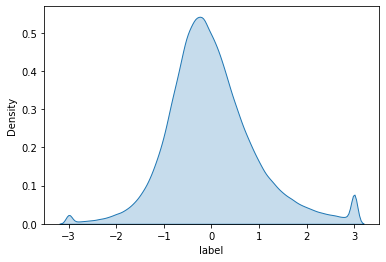

The distribution of y_test:


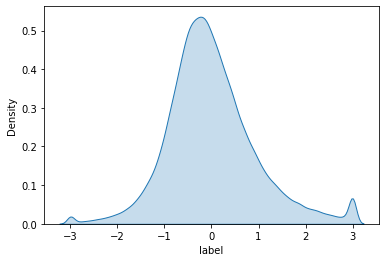

norm data done 

all works done 



In [7]:
X_train = X[X.index.get_level_values(0) <= "2018-12-31"]
X_test = X[X.index.get_level_values(0) >= "2019-01-01"]

# 处理训练集和验证集
result = q.auto_process(X_train, "label", groupby="instrument", datetime="datetime", 
                        split_params={"method": "split", "params": {"test": 0.3}}, select=False, orth=False)

X_train, y_train, X_valid, y_valid = result["X_train"], result["y_train"], result["X_test"], result["y_test"]

# 处理测试集
y_test = X_test.pop("label")
x_mean, x_std = X_test.groupby("datetime").mean(), X_test.groupby("datetime").std()
X_test = q.zscorenorm(X_test, x_mean, x_std)

y_mean = y_test.groupby("instrument").shift(2).groupby("datetime").mean()
y_std = y_test.groupby("instrument").shift(2).groupby("datetime").std()
y_mean.fillna(0.0002, inplace=True)  # 假设年化5%, 则每天应为0.0002
y_std.fillna(0.0189, inplace=True)  # 假设年化波动率为30%, 即0.3, 则每天的波动率应为0.0189

X_test = X_test.groupby("instrument").fillna(method="ffill").dropna()
y_test = y_test[y_test.index.isin(X_test.index)]

In [8]:
X_train.describe()

,CLOSE5,ROC5,BETA5,CLOSE10,ROC10,BETA10,CLOSE20,ROC20,BETA20,CLOSE30,...,AMOUNT10,AMOUNT20,AMOUNT30,AMOUNT60,i1,i6,i7,i8,i9,i10
count,602196.000000,602196.000000,602196.000000,602196.000000,602196.000000,602196.000000,602196.000000,602196.000000,602196.000000,602196.000000,...,602196.000000,602196.000000,602196.000000,602196.000000,602196.000000,602196.000000,602196.000000,602196.000000,602196.000000,602196.000000
mean,-0.012224,0.003294,0.012224,-0.016565,0.005313,0.016565,-0.019179,0.005487,0.019179,-0.019990,...,-0.023166,-0.025958,-0.027523,-0.029326,-0.008053,-0.010788,-0.013369,0.005766,-0.027100,-0.024762
std,0.869754,0.770481,0.869754,0.863459,0.770271,0.863459,0.866820,0.774954,0.866820,0.872124,...,0.877851,0.861253,0.851635,0.843018,0.942734,0.955200,0.939270,0.952907,0.865458,0.881533
min,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,...,-2.612129,-2.370433,-2.090830,-1.977295,-3.000000,-2.792954,-3.000000,-3.000000,-2.035097,-2.384223
25%,-0.448654,-0.316246,-0.457117,-0.463537,-0.312146,-0.440155,-0.489585,-0.313126,-0.427081,-0.507005,...,-0.606867,-0.598234,-0.592411,-0.584764,-0.588385,-0.674502,-0.676077,-0.502161,-0.604735,-0.629262
50%,0.004305,-0.013598,-0.004305,-0.013463,-0.008950,0.013463,-0.040177,0.001163,0.040177,-0.056313,...,-0.181656,-0.202394,-0.213160,-0.228099,-0.109063,-0.134449,-0.166447,0.073659,-0.248630,-0.253541
75%,0.457117,0.295268,0.448654,0.440155,0.299271,0.463537,0.427081,0.302174,0.489585,0.418747,...,0.345329,0.313586,0.290861,0.267368,0.470865,0.511231,0.493505,0.579613,0.303195,0.330689
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  70 out of  91 | elapsed:   18.4s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  80 out of  91 | elapsed:   19.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:   20.9s finished


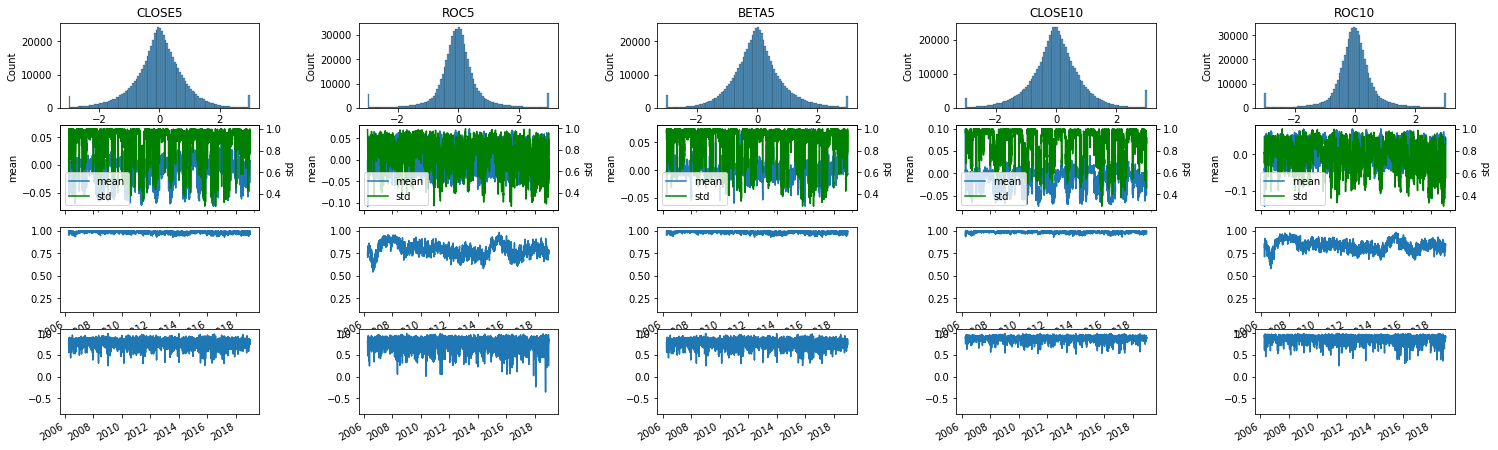

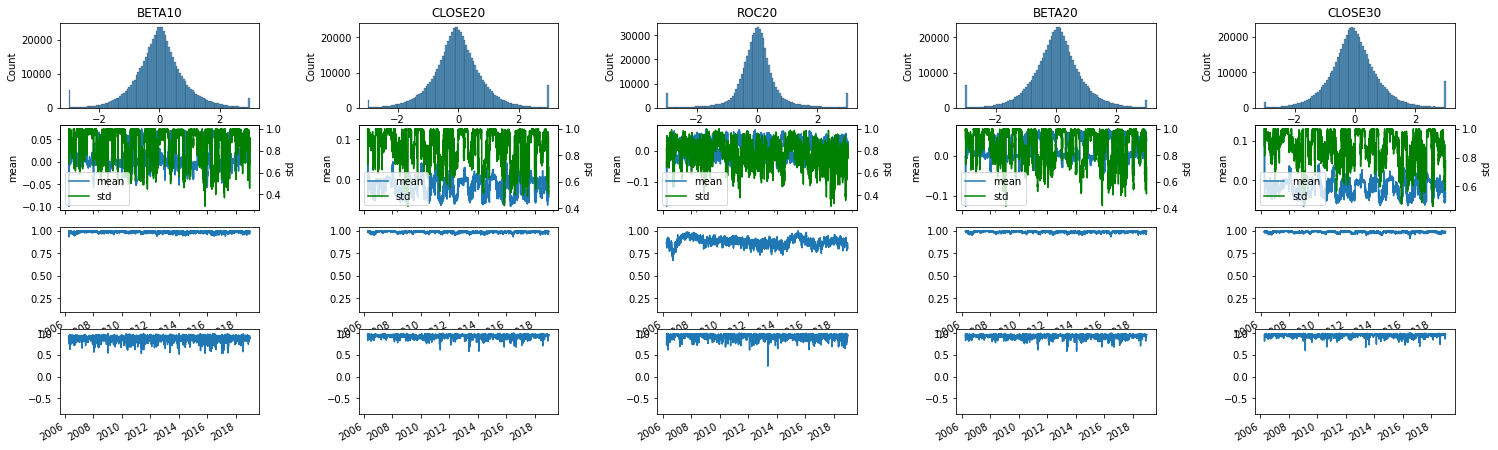

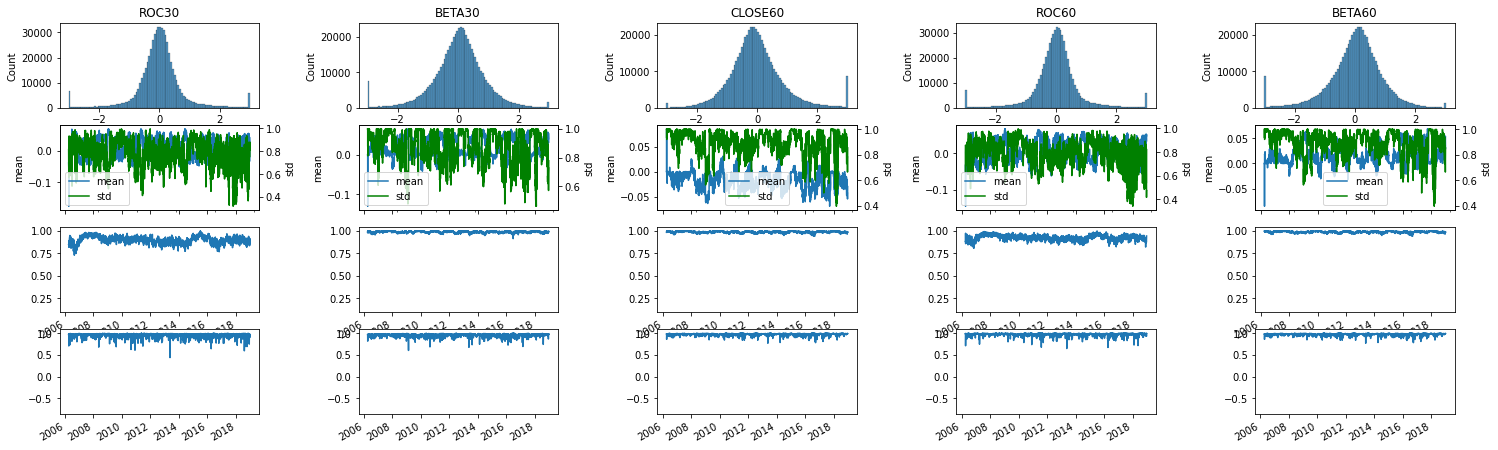

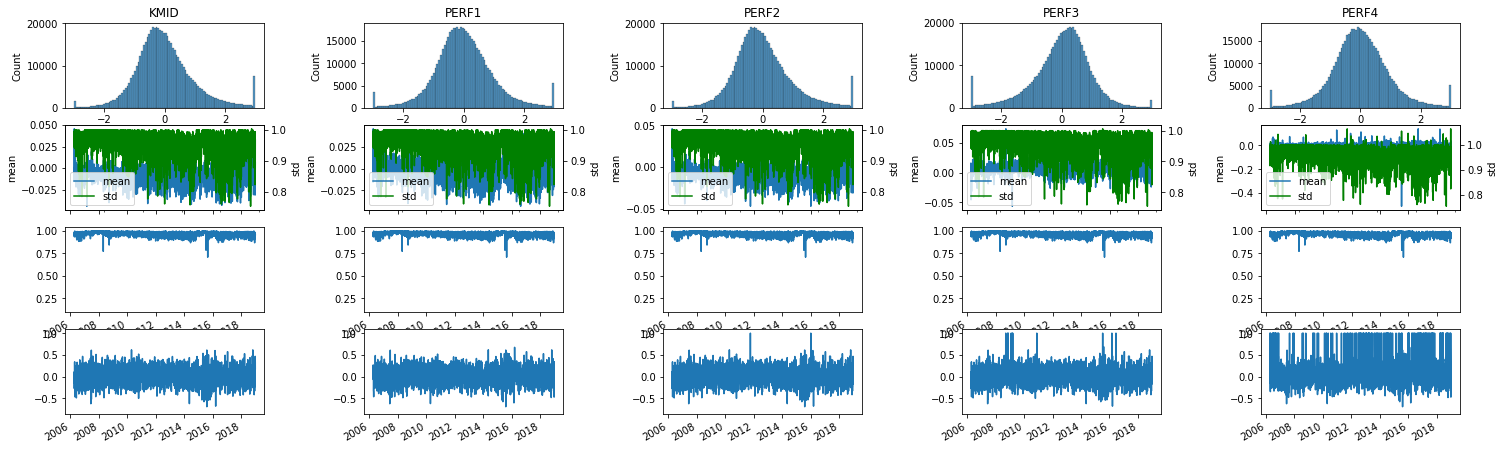

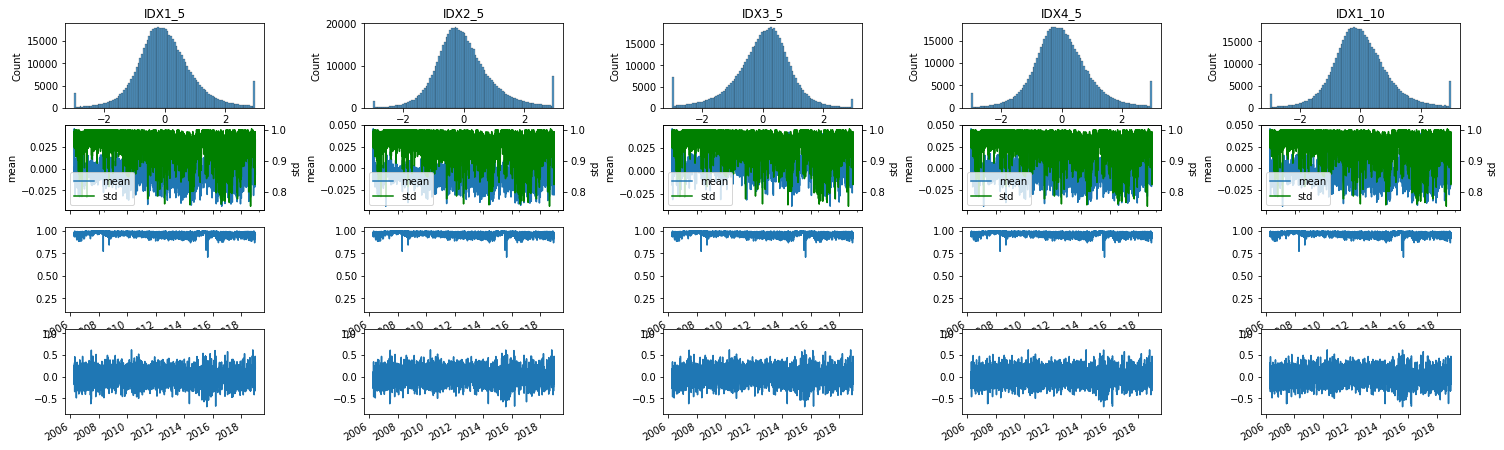

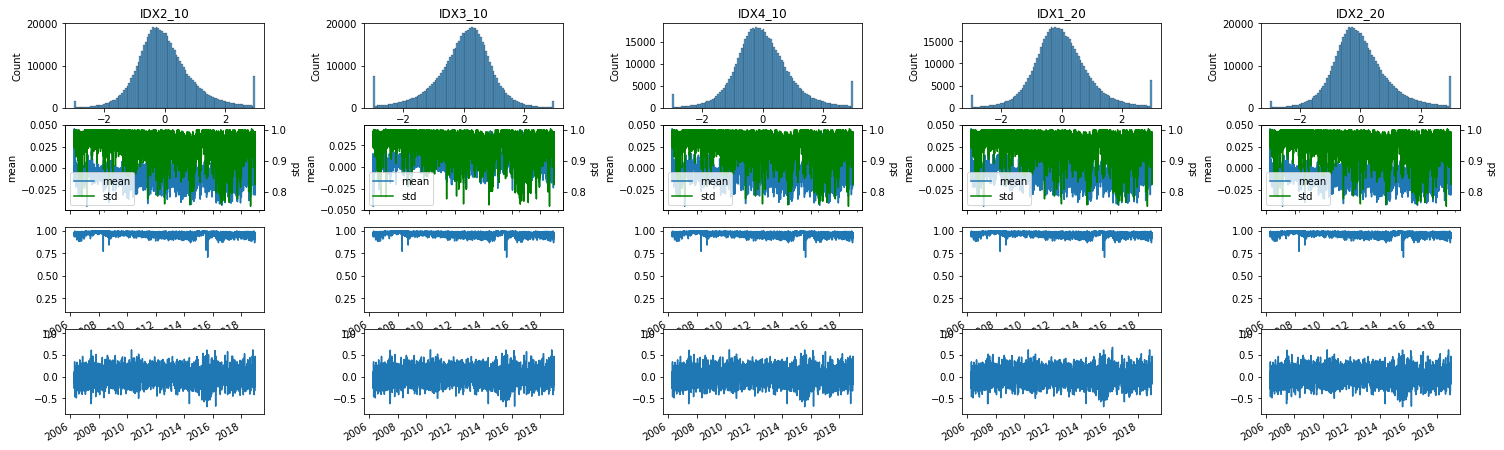

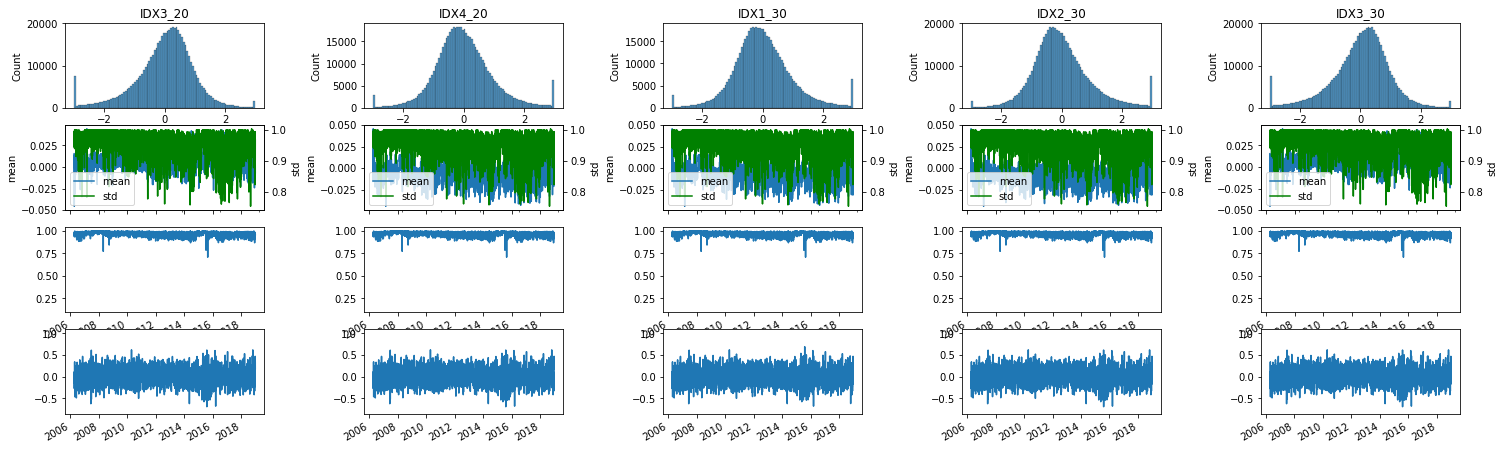

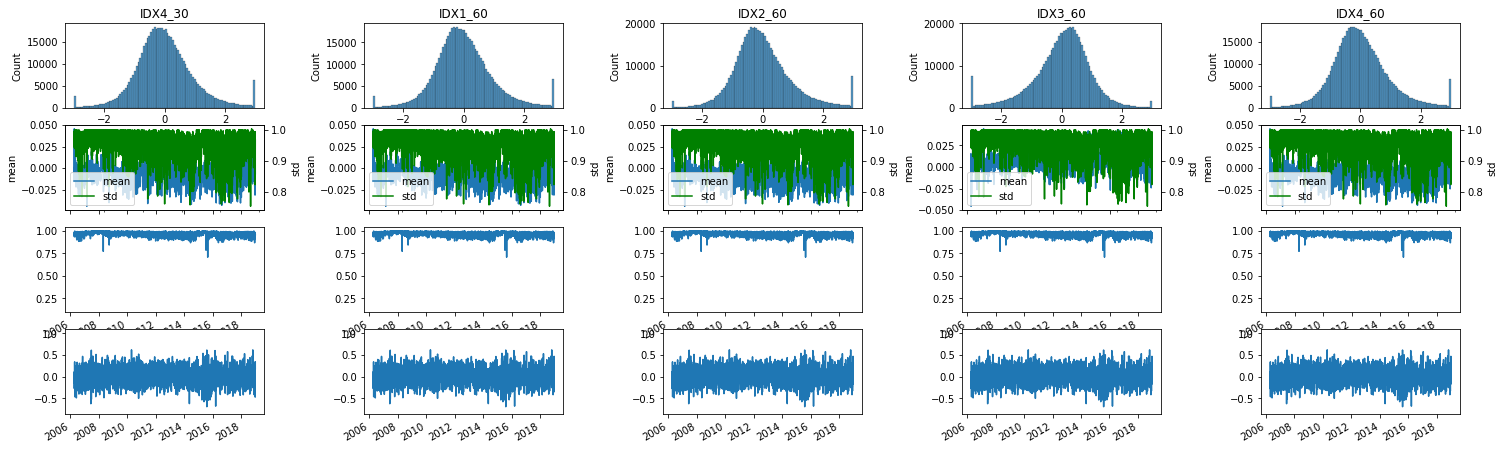

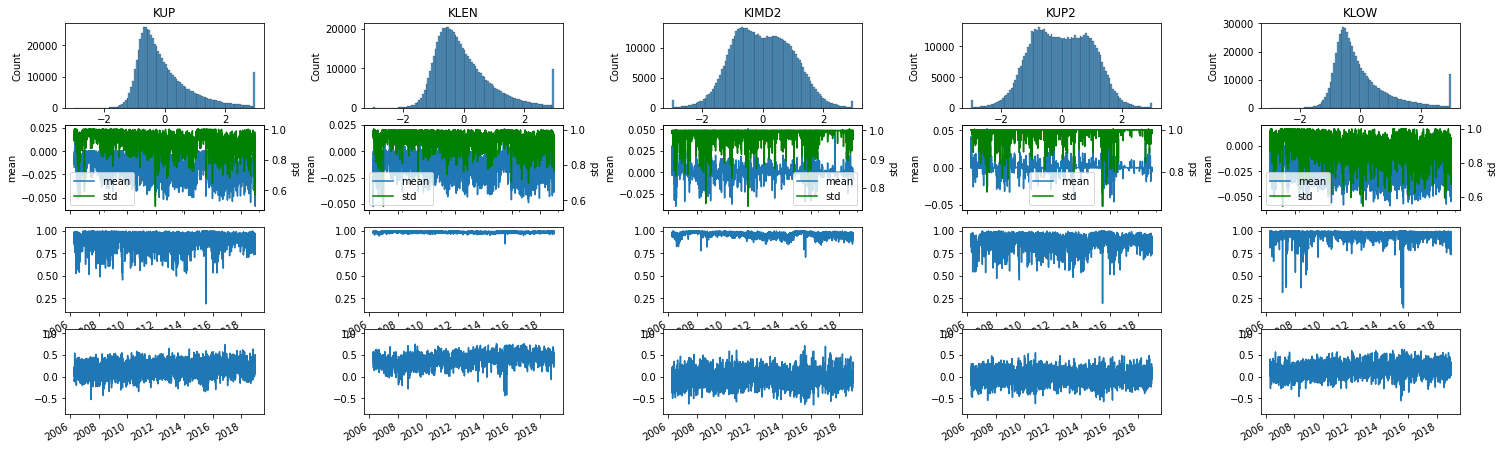

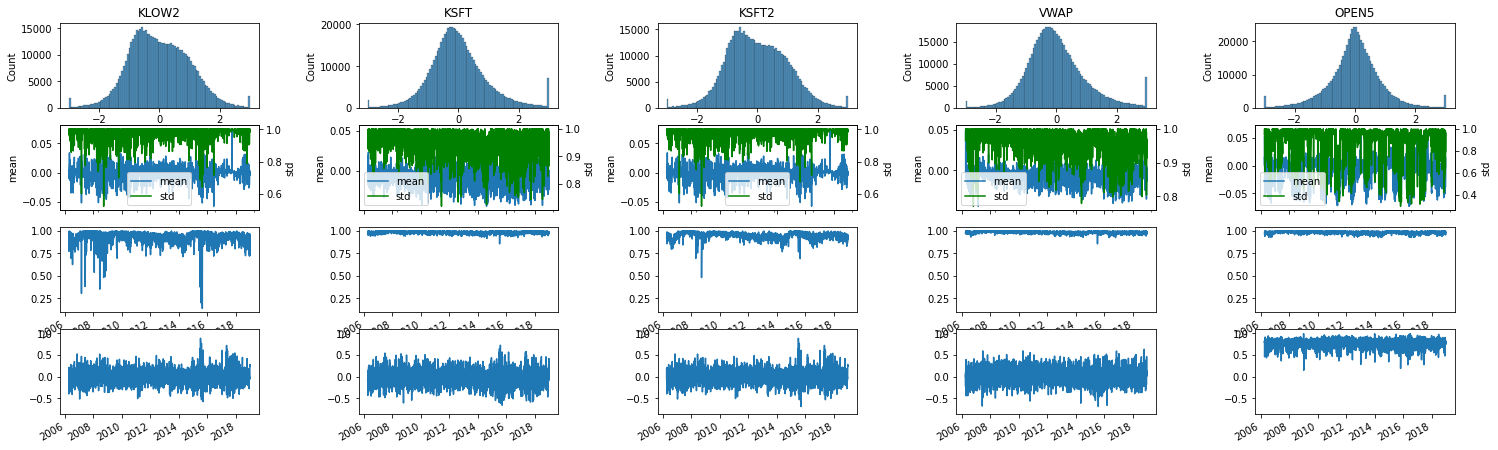

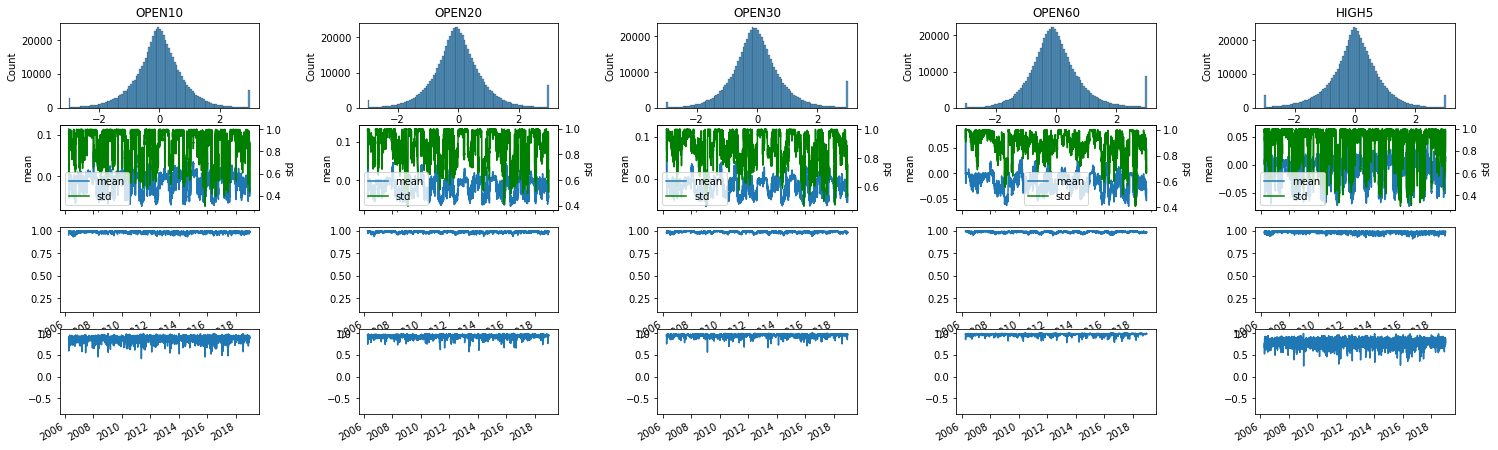

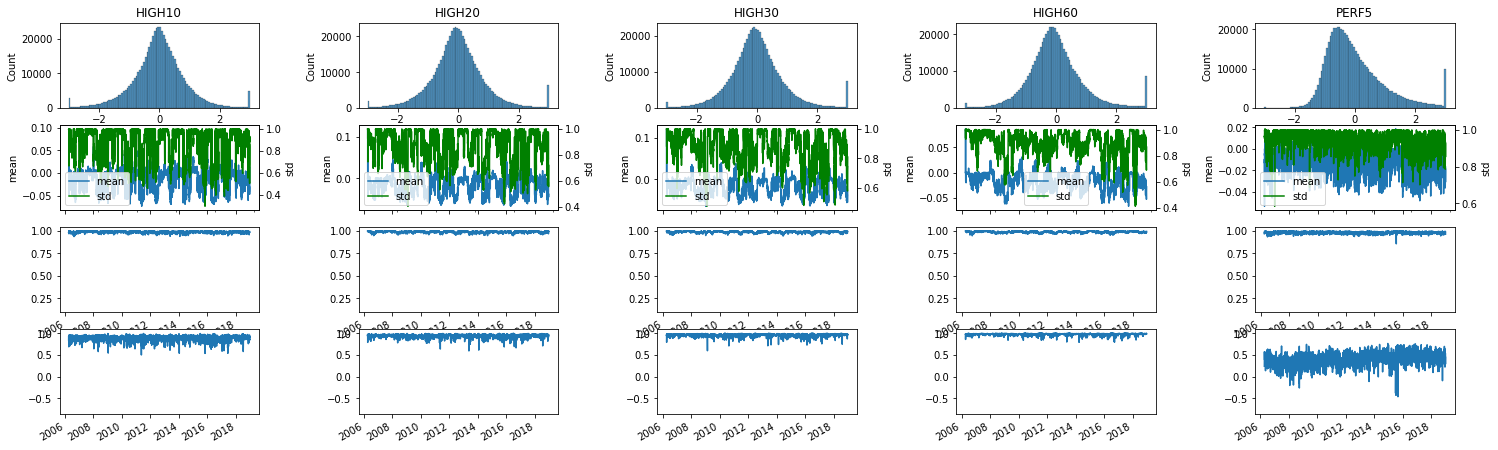

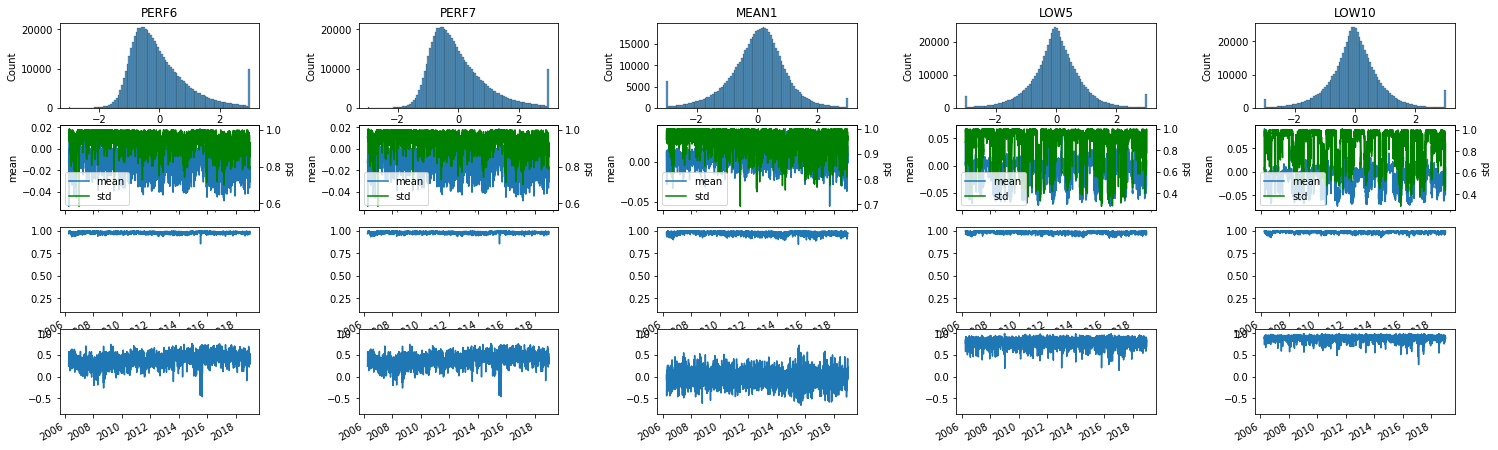

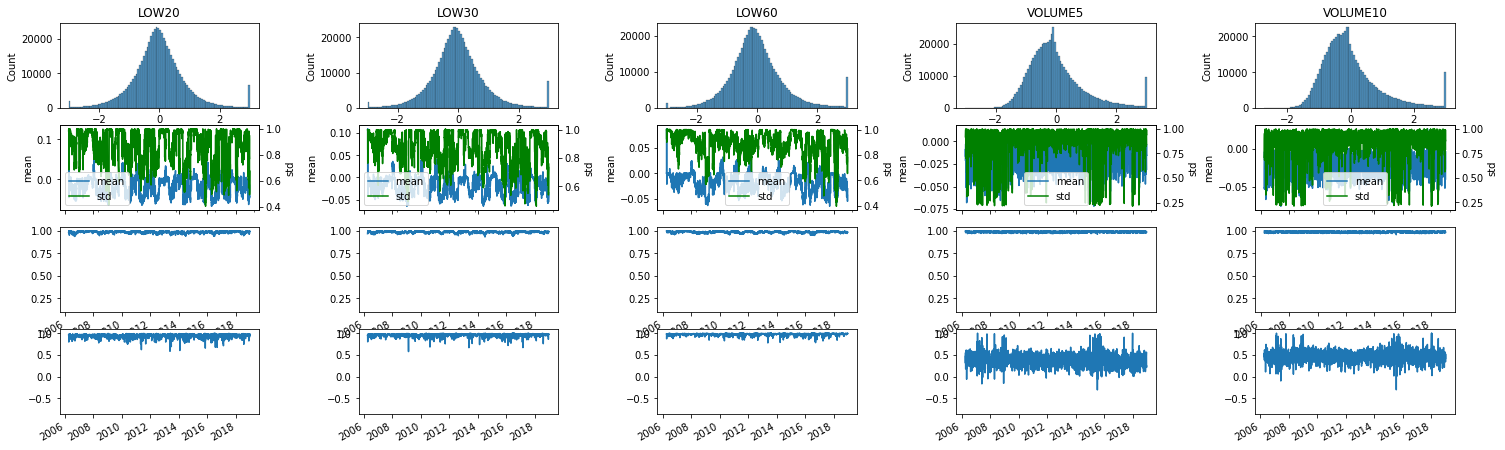

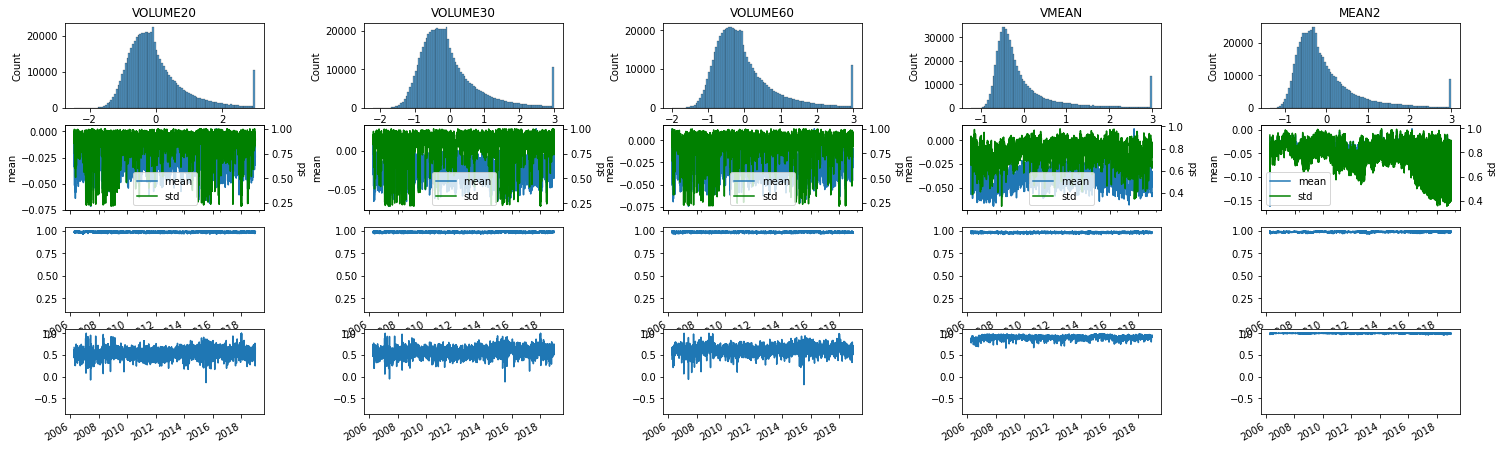

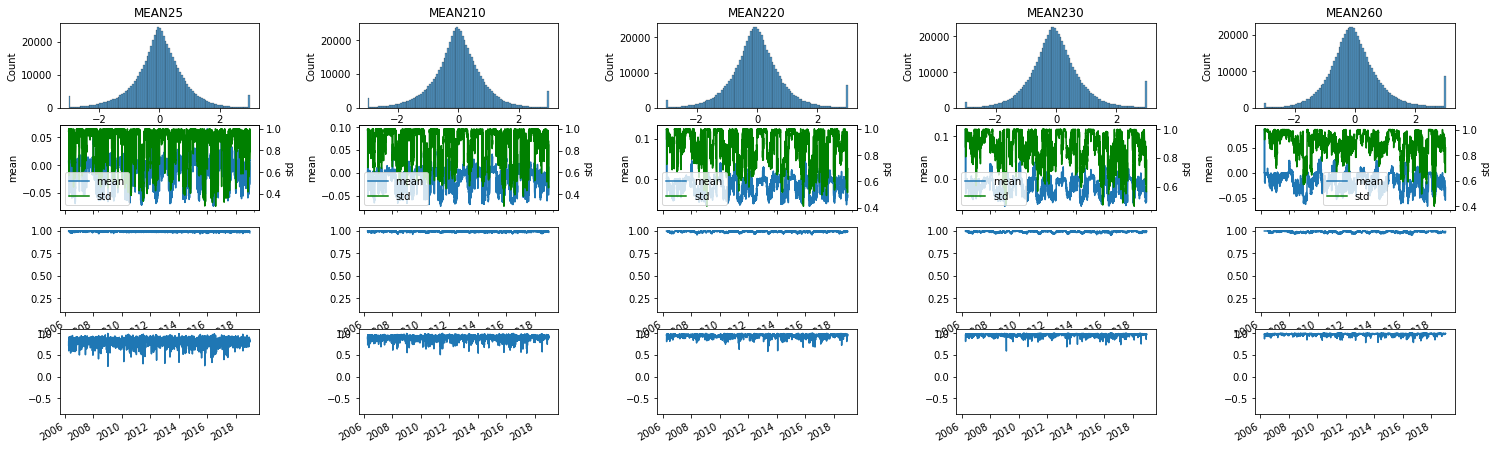

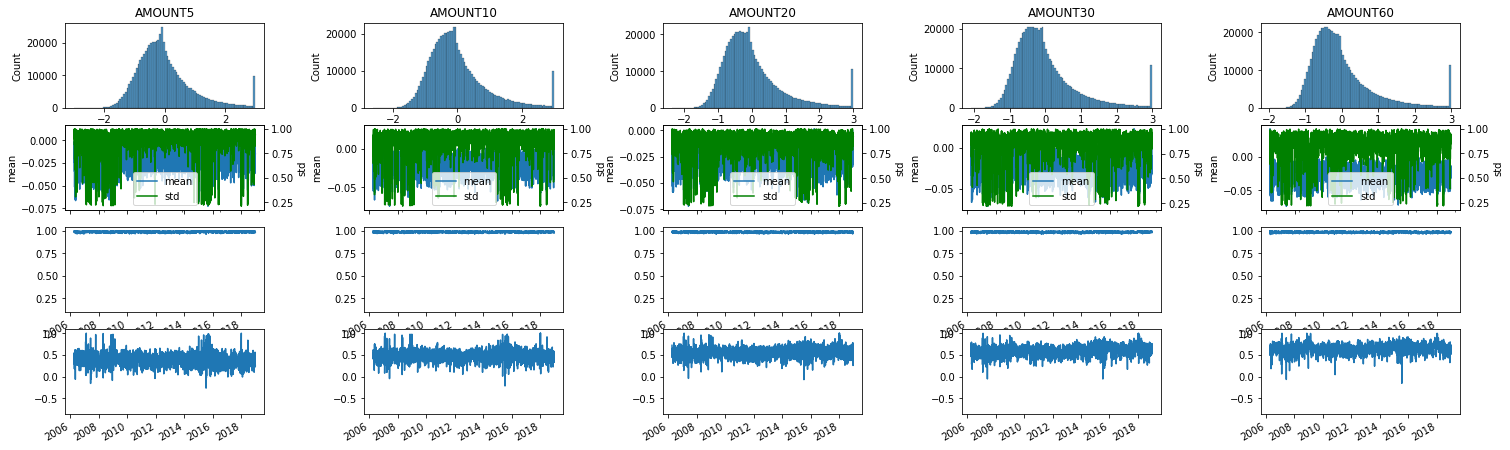

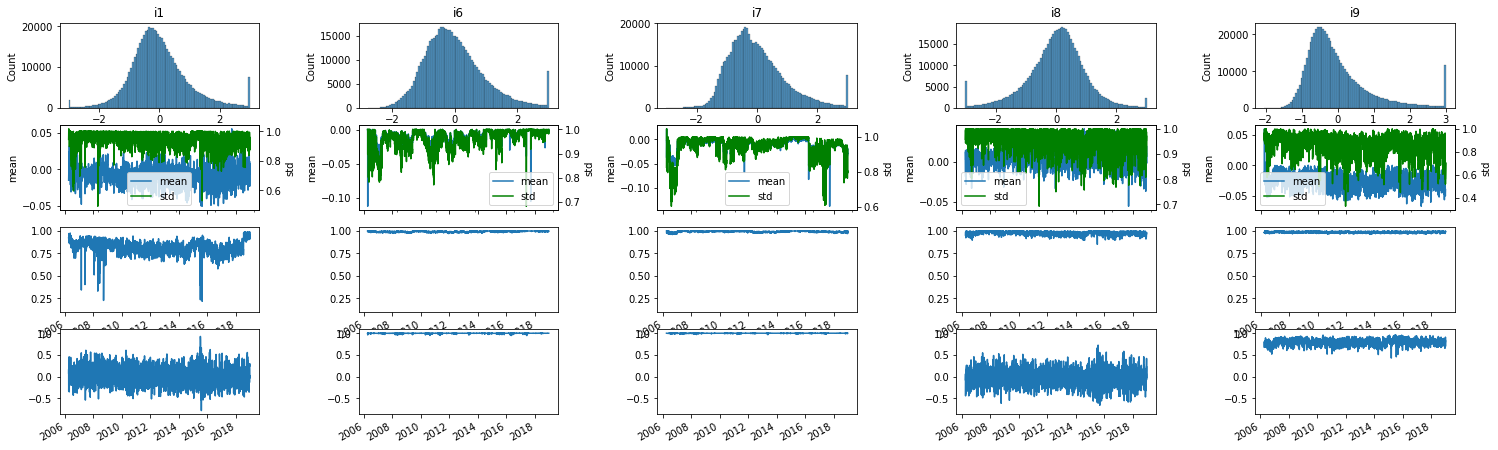

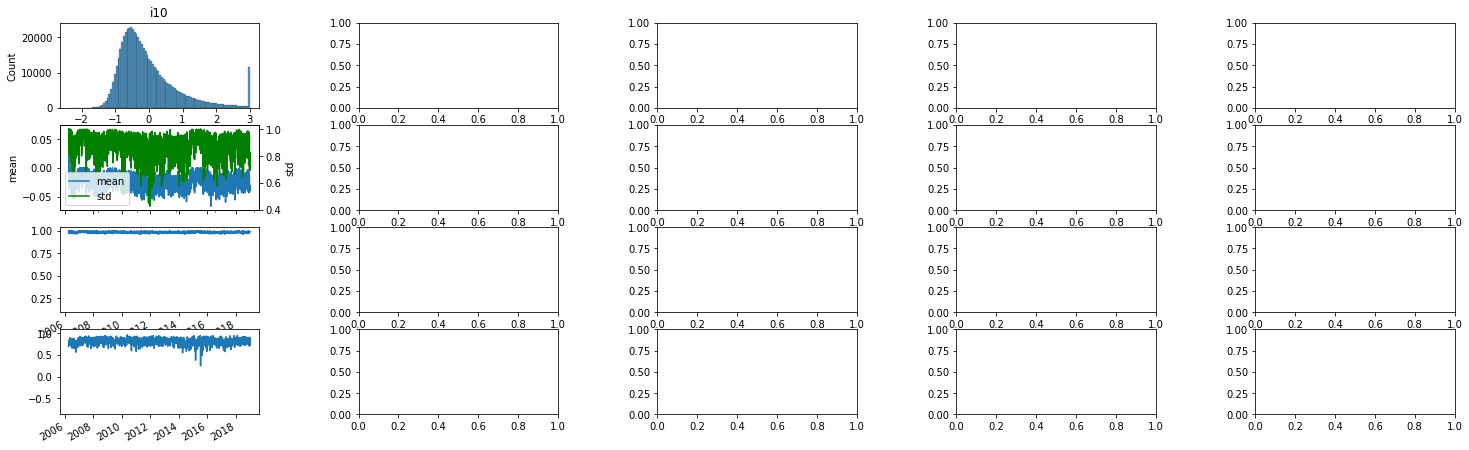

In [9]:
from functools import partial
from qlib.contrib.report.data.ana import CombFeaAna, FeaDistAna, FeaNanAnaRatio, FeaInfAna, FeaMeanStd, ValueCNT, FeaACAna, RawFeaAna

fa_full = CombFeaAna(X_train, FeaDistAna, FeaMeanStd, partial(ValueCNT, ratio=True), FeaACAna)
fa_full.plot_all(sub_fs=(5, 2), col_n=5, wspace=0.5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done  70 out of  91 | elapsed:   46.9s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done  80 out of  91 | elapsed:   47.7s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:   54.0s finished


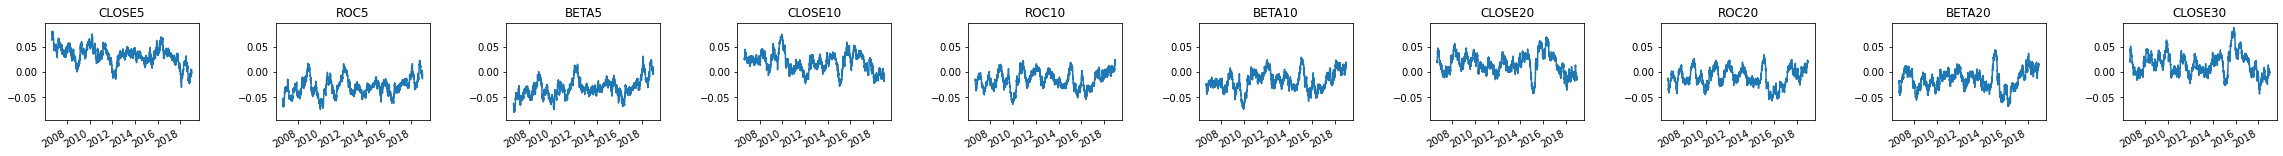

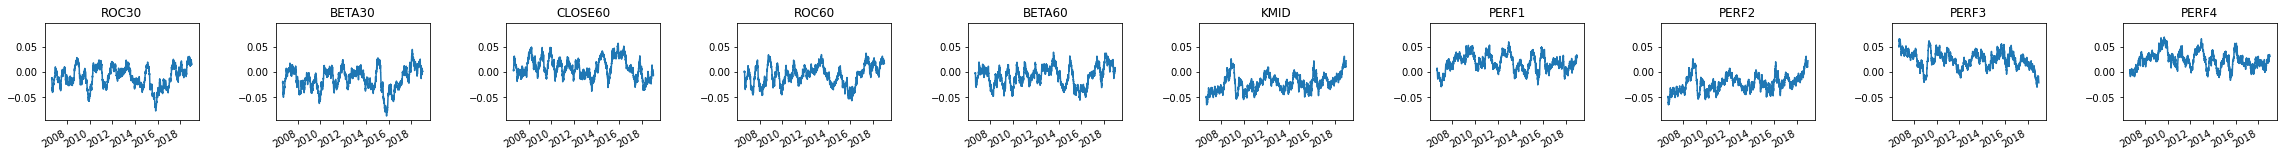

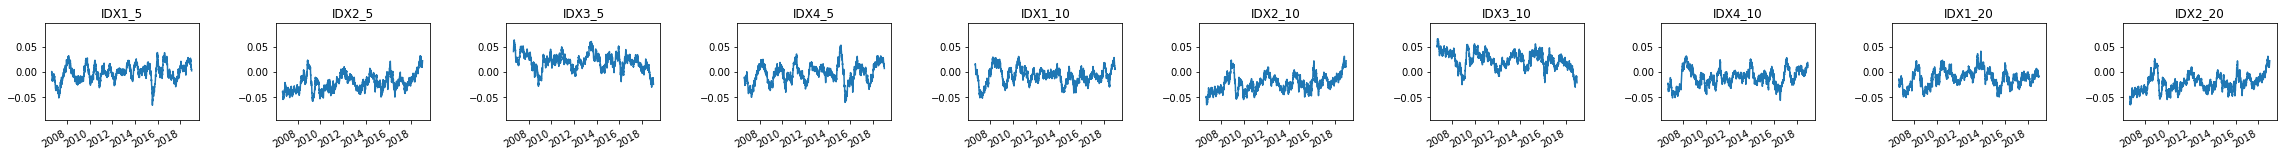

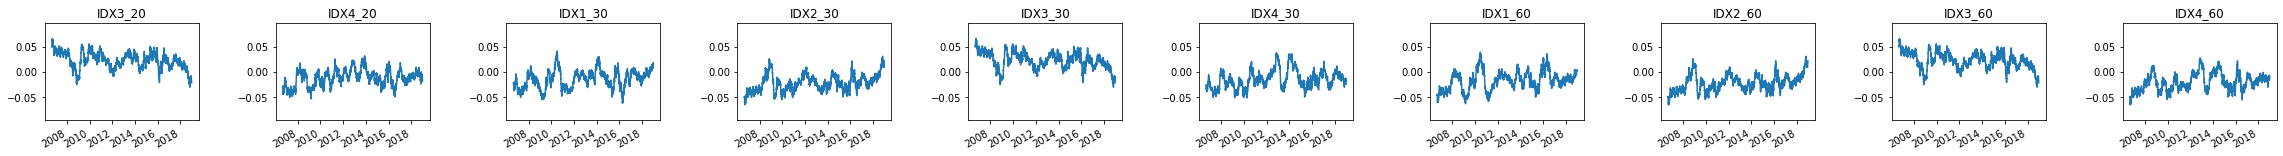

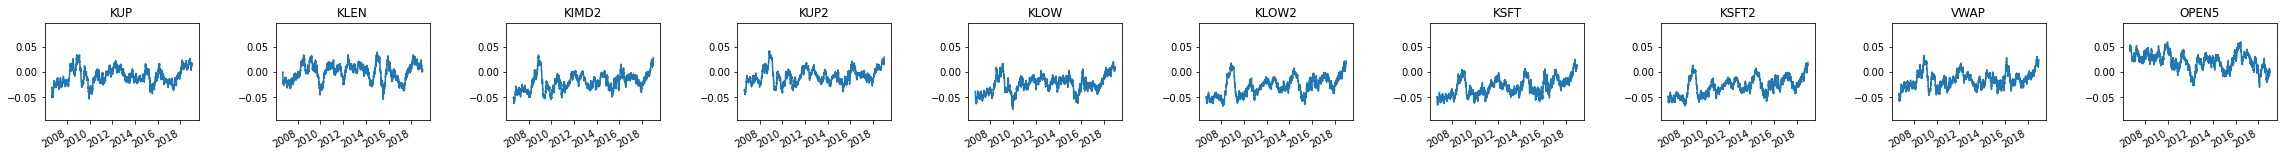

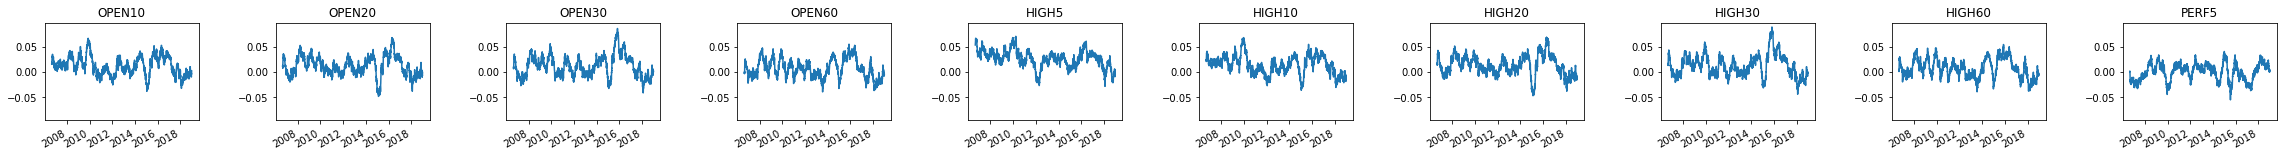

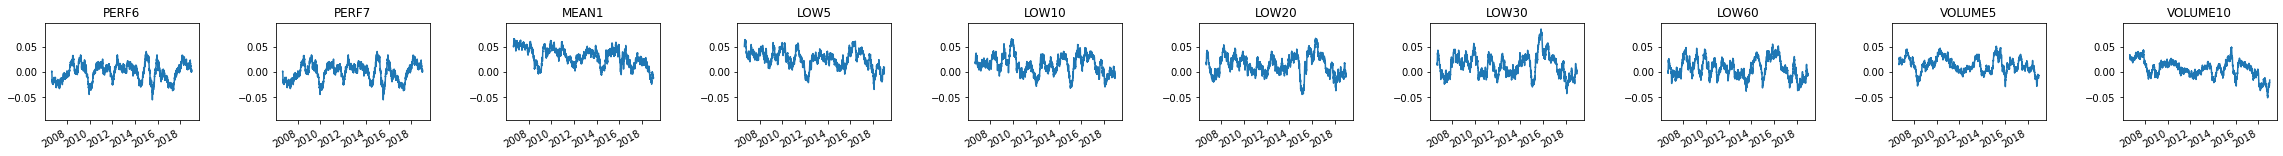

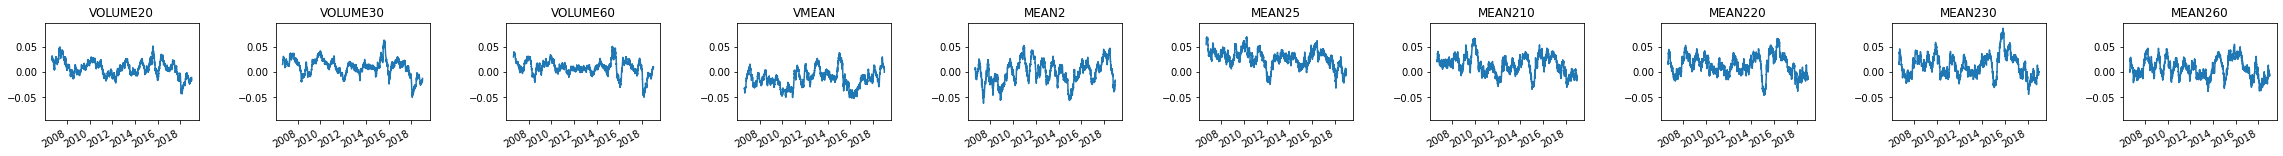

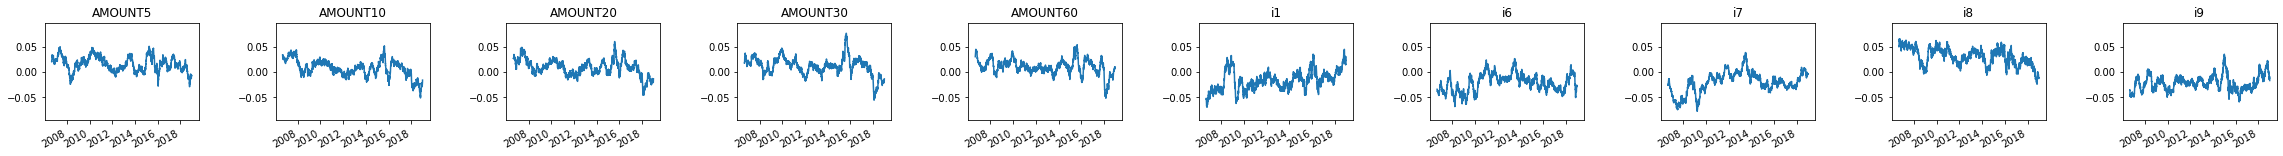

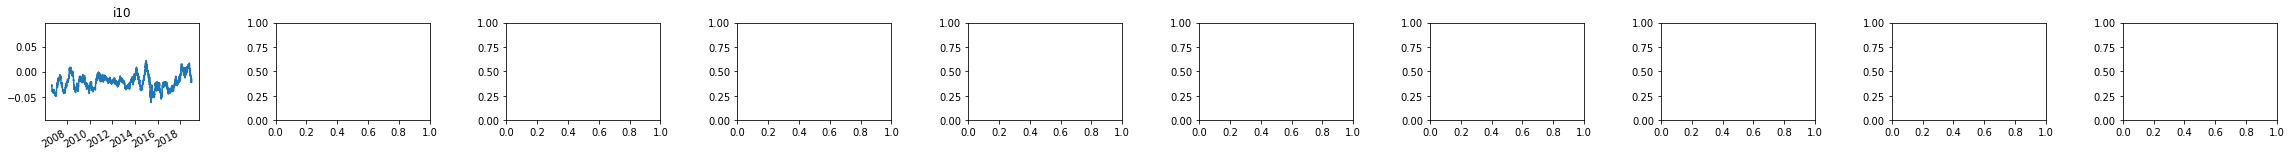

In [10]:
from qlib.contrib.eva.alpha import calc_all_ic

all_ic = calc_all_ic(X_train.to_dict('series'), y_train)
all_ic_df = pd.concat({f: d['ic'] for f, d in all_ic.items()})
all_ic_df = all_ic_df.unstack(0)

fa = RawFeaAna(all_ic_df.rolling(100).mean())
fa.plot_all(sub_fs=(4, 2), col_n=10, wspace=0.5)

<AxesSubplot:>

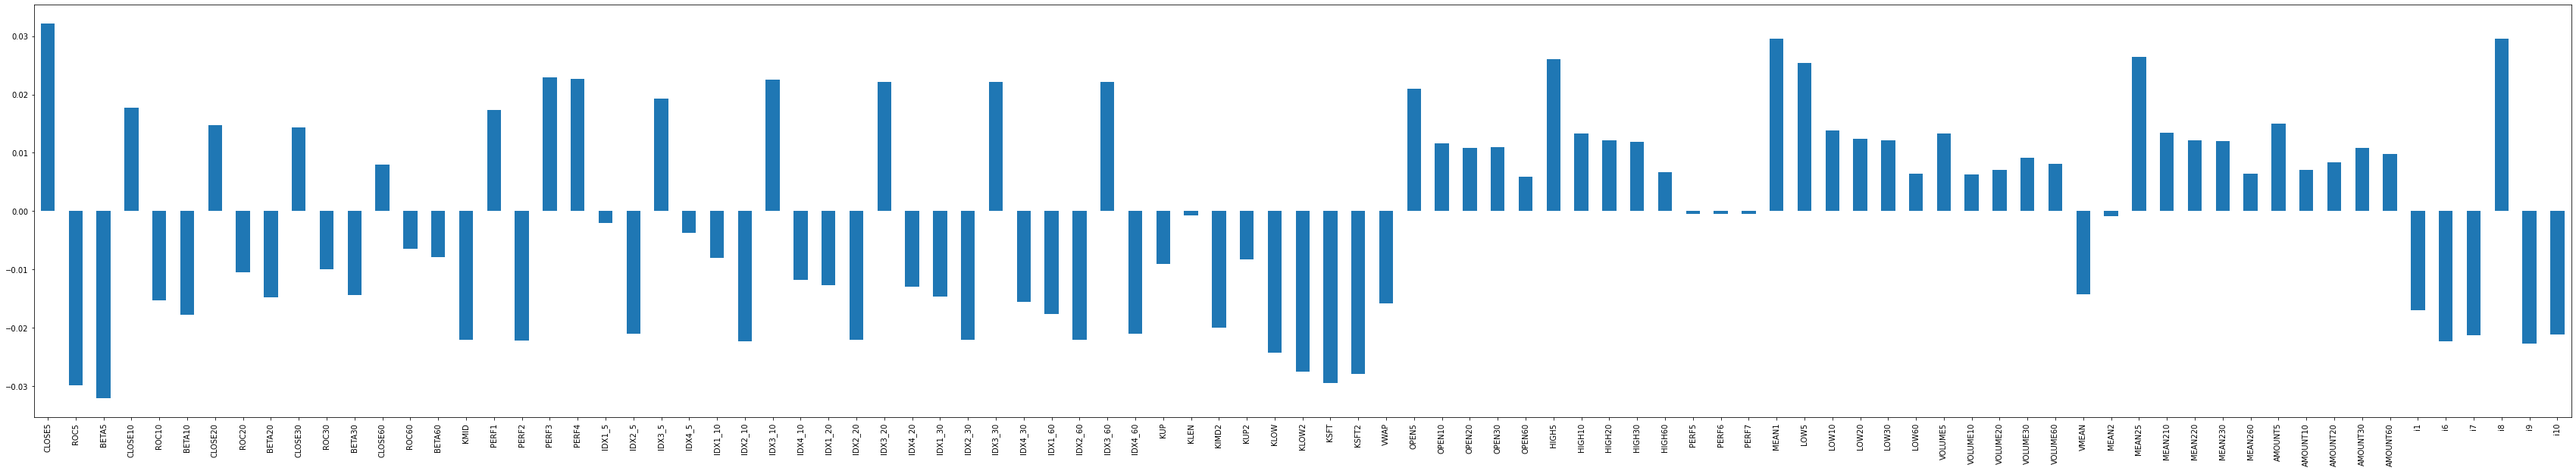

In [11]:
fig = all_ic_df.mean().plot(kind='bar', figsize=(60, 10))
fig

In [12]:
abs(all_ic_df.mean()).mean()

0.015395140310501475

In [13]:
all_ic_df.mean()

CLOSE5     0.032148
ROC5      -0.029888
BETA5     -0.032148
CLOSE10    0.017745
ROC10     -0.015353
             ...   
i6        -0.022377
i7        -0.021318
i8         0.029550
i9        -0.022692
i10       -0.021197
Length: 91, dtype: float64

In [14]:
all_ic_df.mean() / all_ic_df.std()

CLOSE5     0.176034
ROC5      -0.180435
BETA5     -0.176034
CLOSE10    0.094241
ROC10     -0.090008
             ...   
i6        -0.161041
i7        -0.190967
i8         0.182448
i9        -0.147247
i10       -0.139718
Length: 91, dtype: float64

In [15]:
model = q.auto_lgbm(X_train, y_train, X_valid, y_valid)

pred = model.predict(X_test)

pred = pd.DataFrame(pred, columns=["predict"], index=X_test.index)
pred["predict"] += y_mean
pred["predict"] *= y_std
pred.describe()

Training until validation scores don't improve for 30 rounds
[20]	train's l2: 0.886358	valid's l2: 0.896413
[40]	train's l2: 0.884454	valid's l2: 0.89544
[60]	train's l2: 0.883003	valid's l2: 0.894821
[80]	train's l2: 0.881847	valid's l2: 0.894447
[100]	train's l2: 0.88085	valid's l2: 0.89416
[120]	train's l2: 0.879971	valid's l2: 0.893962
[140]	train's l2: 0.879111	valid's l2: 0.893784
[160]	train's l2: 0.878302	valid's l2: 0.893615
[180]	train's l2: 0.877525	valid's l2: 0.89349
[200]	train's l2: 0.876791	valid's l2: 0.893344
[220]	train's l2: 0.876021	valid's l2: 0.893244
[240]	train's l2: 0.875282	valid's l2: 0.893145
[260]	train's l2: 0.874586	valid's l2: 0.893067
[280]	train's l2: 0.873853	valid's l2: 0.893028
[300]	train's l2: 0.873111	valid's l2: 0.892966
[320]	train's l2: 0.872352	valid's l2: 0.892931
[340]	train's l2: 0.871603	valid's l2: 0.89287
[360]	train's l2: 0.870917	valid's l2: 0.892807
[380]	train's l2: 0.870194	valid's l2: 0.892771
[400]	train's l2: 0.869549	valid's l

,predict
count,280721.000000
mean,-0.000179
std,0.001772
min,-0.038634
25%,-0.001090
50%,-0.000114
75%,0.000814
max,0.016618


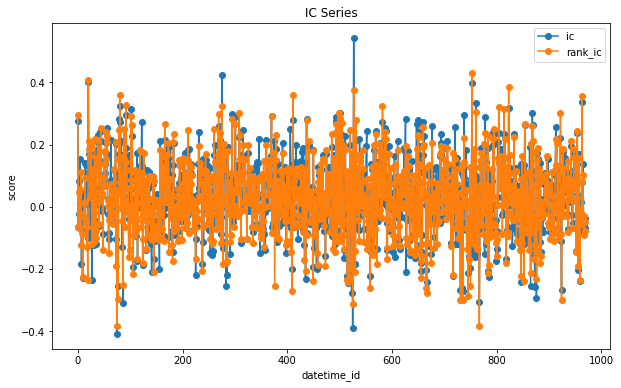

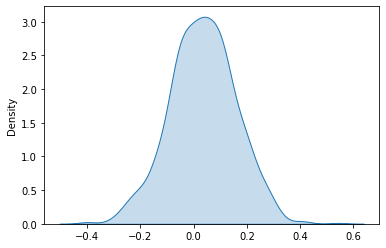

ic= 0.033915743238514956 icir= 0.27225310329207336 rank_ic= 0.027400472694336618 rank_icir= 0.2225327961163124


0.02809231488900346

In [16]:
ic, icir, rank_ic, rank_icir = q.ic_ana(pred["predict"], y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred["predict"].values, y_test)
r

In [17]:
from scutquant import executor, report

df_test = df[df.index.get_level_values(0) >= "2019-01-01"]
# 将预测值处理成回测需要的格式
pred = executor.prepare(pred, df_test, price='mean_price', volume='vol')
pred

predict       price     volume
time       code                                      
2019-01-02 000001.SZ  0.000817    9.252048  539386.32
           000002.SZ -0.001189   24.120738  247010.28
           000063.SZ  0.001193   19.088275  649682.72
           000069.SZ  0.000640    5.999183  403924.79
           000100.SZ -0.000957    2.515065  890514.27
...                        ...         ...        ...
2022-12-27 688363.SH -0.000791  136.312691   67620.51
           688396.SH  0.001245   53.127821   22894.05
           688561.SH -0.000546   65.791178   17585.16
           688599.SH -0.002152   62.192181  170829.80
           688981.SH -0.000080   41.078327   61293.26

[280267 rows x 3 columns]

Accuracy of Prediction: 0.5285459936417773


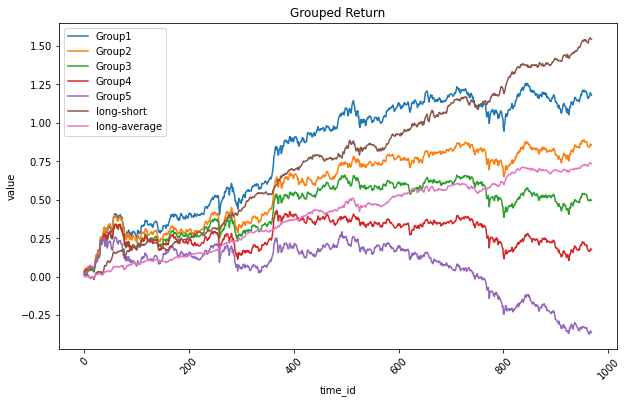

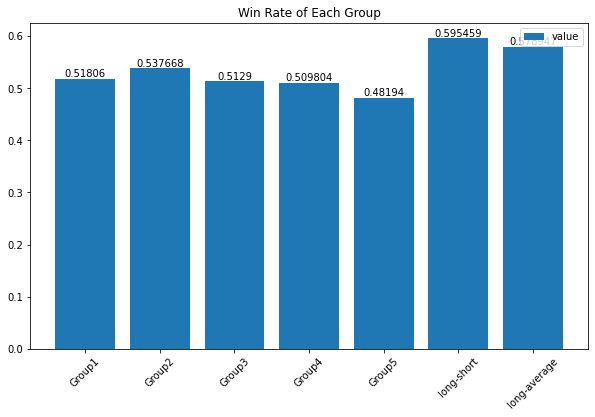

In [18]:
report.group_return_ana(pred, y_test)

In [19]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "SigmaStrategy",  # 做多预测值前20%且值大于0%的股票, 做空后20%且值小于0%的股票. 自动平仓
        "kwargs": {
            "sigma": 1,
            "auto_offset": False,
            "offset_freq": 2, # 应为delta_t + 1, 例如目标值是close_-2 / close_-1 - 1, 则delta_t = 1
            "buy_only": False,  # =True时，只做多不做空(在A股做空有一定的难度)
            "short_volume": 5000,
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": None,  # 由于数据已经是以手为单位, 故无需二次处理
            "max_volume": 0.5  # 手数随可用资金而改变，最大不会超过股票当天成交量的x%(例如T+1时下单，下单手数不会超过T时成交量的x%)
        }
    },
    "account": None,  # 使用默认账户, 即初始资金为1亿, 无底仓
    "trade_params": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0005,  
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)

Annualized Return: 0.22924009092545328
Annualized Volatility: 0.838882434357082
Annualized Return(Benchmark): 0.07899686073853784
Annualized Volatility(Benchmark): 0.3390023870788162 

Cumulative Rate of Return: 1.2114367136854103
Cumulative Rate of Return(Benchmark): 0.33958556303554865
Cumulative Excess Rate of Return: 0.8718511506498616 

Max Drawdown: -0.3697541984689017
Max Drawdown(Benchmark): -0.5462600364770351 

Sharpe Ratio: 1.8752161351982781
Sortino Ratio: 3.55913779392892
Information Ratio: 0.9063603333703224 

Beta: 1.9886087489437954
Alpha: -0.02209415338412024
Epsilon: 0.25460102566426074
Profitable Days(%): 0.8771929824561403


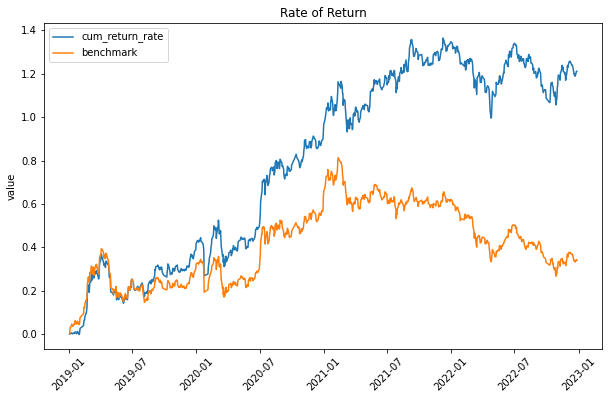

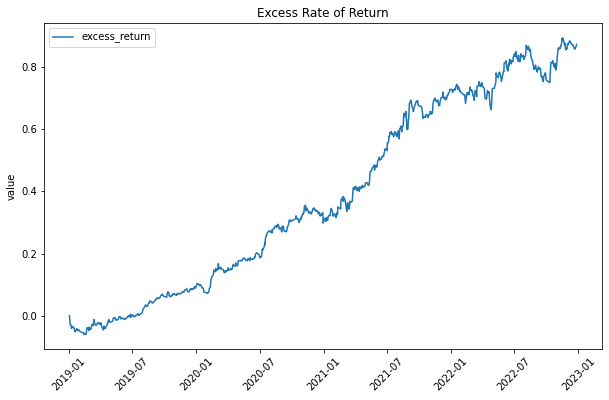

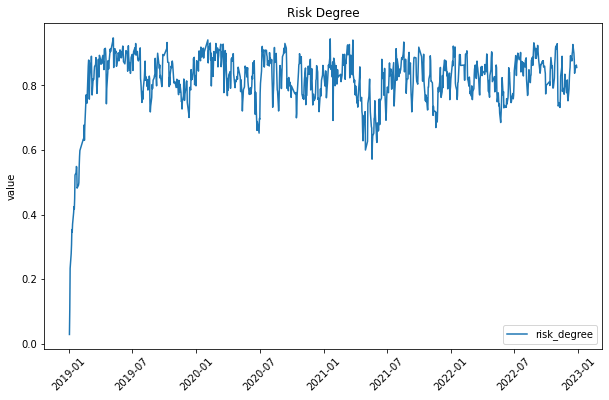

In [20]:
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=365, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节

In [21]:
ic_performance = pd.DataFrame({"ic_mean": all_ic_df.mean(), "icir": all_ic_df.mean() / all_ic_df.std()})
ic_performance.to_csv("factors_ic.csv")